# Assignment 1: Time Series Forecast With Python (Seasonal ARIMA)

**Lecturer**: Vincent Claes<br>
**Authors:** Bryan Honof, Jeffrey Gorissen<br>
**Start Date:** 19/10/2018
    
**Objective:** Visualize and predict the future temperatures via ARIMA

**Description:** In this notebook we take a close look at the data

## Table of contents

1. [Import libraries](#Import-Libraries)
2. [Load in the data](#load-data)
3. [Wrange the data](#)
4. [A bit of Exploratory Data Analysis (EDA)](#EDA) 

## 1. Import Libraries <a name="Import-Libraries"></a>

In [31]:
import warnings

import pandas            as pd
import seaborn           as sns
import itertools         as it
import statsmodels.api   as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools     import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

## 2. Load in the data <a name="load-data"></a>

In [3]:
data_csv = pd.read_csv('./data/data.csv')

In [4]:
data_csv.tail(5)

,dateTime,temperature
854,2018-11-19 21:00:00,18.23
855,2018-11-19 21:15:00,18.16
856,2018-11-19 21:30:00,17.57
857,2018-11-19 21:45:00,17.52
858,2018-11-19 22:00:00,16.74


In [5]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 2 columns):
dateTime       859 non-null object
temperature    859 non-null float64
dtypes: float64(1), object(1)
memory usage: 13.5+ KB


## 3. Wrangle the Data <a name="Wrangle-the-Data"></a>

Since we want our dataframe to be a time series we will have to convert our index because, at this moment it is not a ```datetimeIndex```.<br>
We can do this with the help of the ```pandas``` methods ```to_datetime()``` and ```set_index```.

In [6]:
data = pd.DataFrame()

# Convert the creation_date column to datetime64
data['dateTime'] = pd.to_datetime(data_csv['dateTime'])
# Convert the value column to float
data['temperature'] = pd.to_numeric(data_csv['temperature'])

# Set the dateTime column as index
data = data.set_index(['dateTime'])

# Sort the dataFrame just to be sure...
data = data.sort_index()

# Double check the results
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 859 entries, 2018-11-10 23:30:00 to 2018-11-19 22:00:00
Data columns (total 1 columns):
temperature    859 non-null float64
dtypes: float64(1)
memory usage: 13.4 KB


As we can see we successfully convert our index to a ```datetimeIndex``` thus making it a time series dataframe.

## 4. A bit of Exploratory Data Analysis (EDA) <a name="EDA"></a>

### Initial Inspections

We can have a look at how frequent some temperatures are. We rounded the values in the dataFrame since this resulted in a much nicer plot.

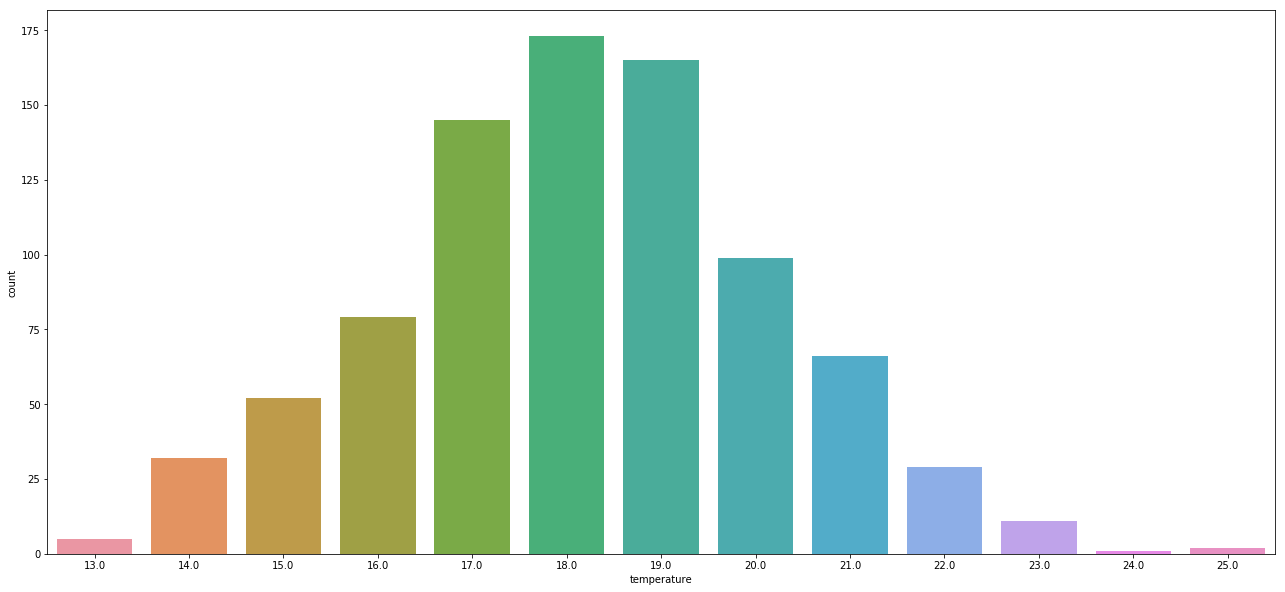

In [7]:
plt.figure(figsize=(22,10))
sns.countplot(data['temperature'].round())
plt.show()

In [8]:
print(data.describe())
print("======================")
print(data.dtypes)

       temperature
count   859.000000
mean     18.180058
std       2.025176
min      12.910000
25%      16.955000
50%      18.240000
75%      19.460000
max      25.260000
temperature    float64
dtype: object


In [9]:
data.head(5)

,temperature
dateTime,
2018-11-10 23:30:00,21.48
2018-11-10 23:45:00,20.32
2018-11-11 00:00:00,20.91
2018-11-11 00:15:00,21.33
2018-11-11 00:30:00,22.18


In [10]:
data.tail(5)

,temperature
dateTime,
2018-11-19 21:00:00,18.23
2018-11-19 21:15:00,18.16
2018-11-19 21:30:00,17.57
2018-11-19 21:45:00,17.52
2018-11-19 22:00:00,16.74


Let's take a look at our graph again just because it's pretty.

Also this graph can tell us the seasonallity of the data. We can (kinda) see a seasonal pattern that repeats iself every day. At the beginning of the day the temperature drops and at around the time most people wake up in the house the tempearture rises. When people leave for work/school the temperature drops a little again and rises when everyone comes home again.

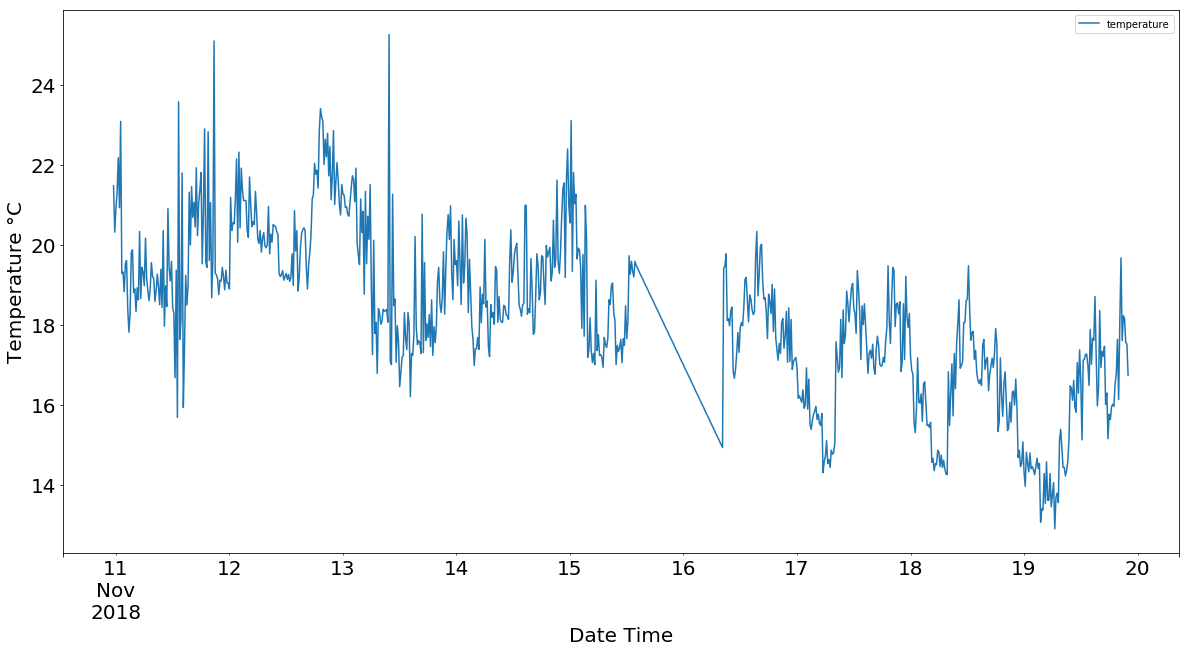

In [27]:
data.plot(figsize=(20, 10), fontsize=20)
plt.xlabel('Date Time', fontsize=20)
plt.ylabel('Temperature °C', fontsize=20)
plt.show()

We can take a Dickey-Fuller test that will tests the null hypothesis that a unit root is present in an autoregressive model.

In [12]:
# Dickey-Fuller Test Function
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    print ("==============================================")
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

In [13]:
# Stationarity Check - Lets do a quick check on Stationarity with Dickey-Fuller Test 
# Convert the DF to series first
ts = data['temperature']
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.945861
p-value                          0.040269
#lags Used                       9.000000
Number of Observations Used    849.000000
Critical Value (1%)             -3.438076
Critical Value (5%)             -2.864950
Critical Value (10%)            -2.568586
dtype: float64


In [30]:
adfuller_result = adfuller(data.temperature)
print("The p-value for the ADF test is ", adfuller_result[1])

The p-value for the ADF test is  0.04026901113661623


In [32]:
chg_temp = data.temperature.diff()
chg_temp = chg_temp.dropna()

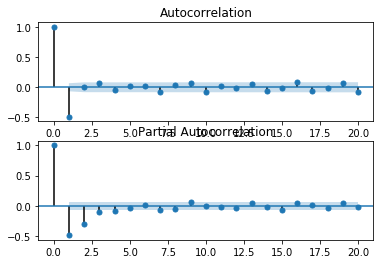

In [33]:
# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1])
plt.show()

In [37]:
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

# Fit the data to an AR(1) model and print AIC:
mod = ARMA(chg_temp, order=(1, 0))
res = mod.fit()
print("The AIC for an AR(1) is: ", res.aic)

# Fit the data to an AR(2) model and print AIC:
mod = ARMA(chg_temp, order=(2, 0))
res = mod.fit()
print("The AIC for an AR(2) is: ", res.aic)

# Fit the data to an MA(1) model and print AIC:
mod = ARMA(chg_temp, order=(0, 1))
res = mod.fit()
print("The AIC for an MA(1) is: ", res.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod = ARMA(chg_temp, order=(1, 1))
res = mod.fit()
print("The AIC for an ARMA(1,1) is: ", res.aic)

The AIC for an AR(1) is:  2426.5644488824223
The AIC for an AR(2) is:  2344.305240506462
The AIC for an MA(1) is:  2332.422330242459
The AIC for an ARMA(1,1) is:  2330.266322953276


/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


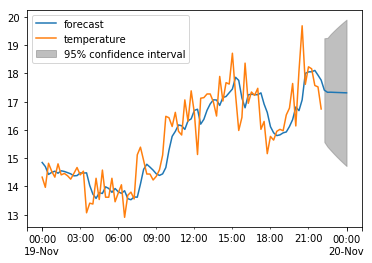

In [43]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast interest rates using an AR(1) model
mod = ARIMA(data.temperature, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(start='2018-11-19', end='2018-11-20')
plt.show()

We are also going to plot Moving, Rolling, Mean & Variance to find some insights into the data.

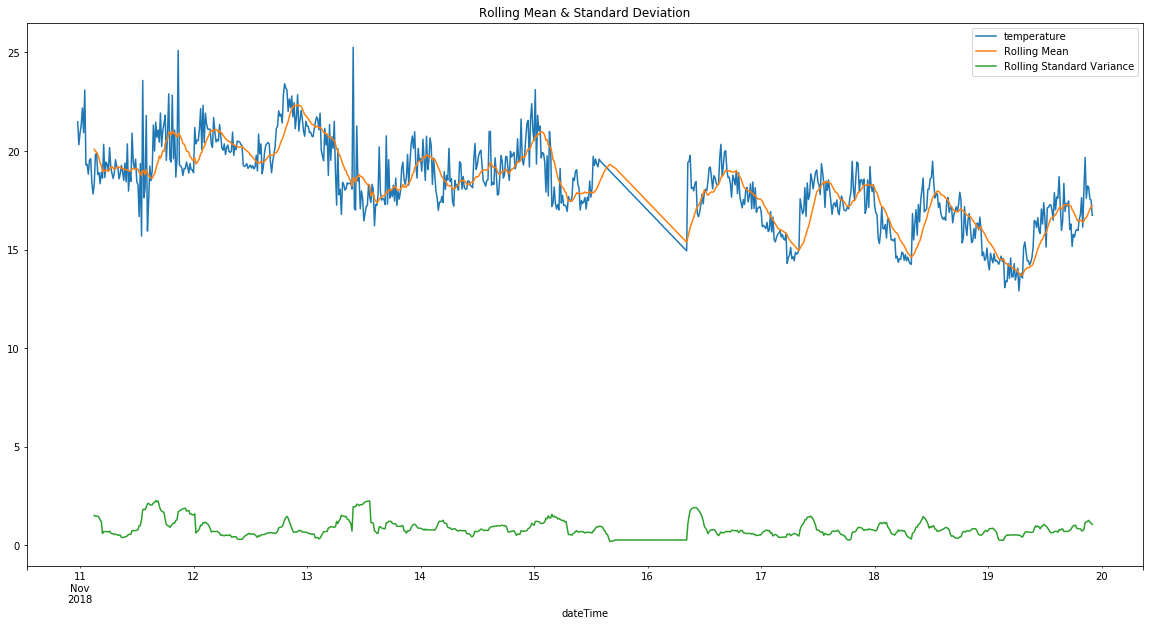

In [14]:
# Rolling Statistics
rolmean = ts.rolling(window=15).mean()
rolvar = ts.rolling(window=15).std()

data.plot(label='Original', figsize=(20, 10))
rolmean.plot(label='Rolling Mean')
rolvar.plot(label='Rolling Standard Variance')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

The ```Rolling Mean``` data looks perfect to train our model on so we will save it to a ```.csv```.

In [15]:
# Since you can see some of the data in the beginning is missing we will just drop all the NaN values
rolmean = rolmean.dropna()

rolmean.round(2).to_csv('./data/rolmean_data.csv',
                       header=['temperature'])

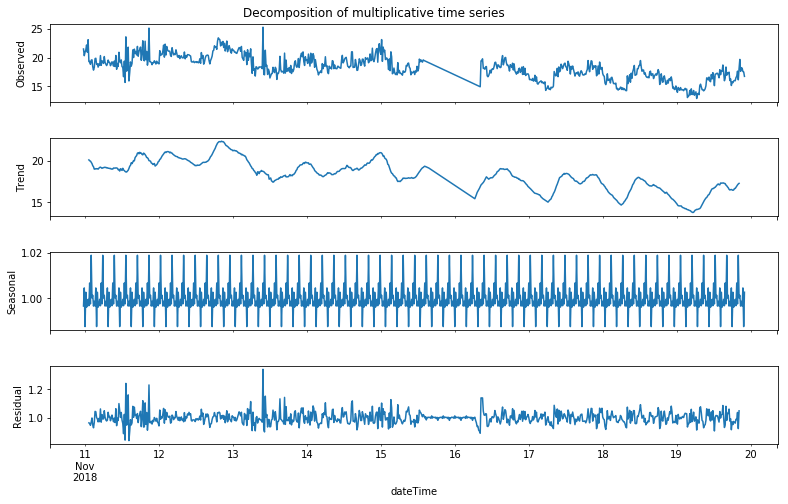

In [16]:
decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative', freq=15)

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

[next notebook](./4_model_selection.ipynb)